# Introduction

* __Objective__
 * Build an end-to-end predictive machine learning model that can take any new song we like and predict its genre.


* __Goals__
 * Find premade datasets and or curate a training set that's based on Spotify's API for the predictive model.
 * Implement basic preprocessing & EDA and feature analysis (engineering, selection, etc).
 * Develop a model that shows good intelligence in genre prediction, also include a random baseline model for comparison.
 * Assess which genres were better predicted and which ones didn't do as well.
 * Build a __prediction function__ that you can give a song title __and__ artist to that's capable of querying Spotify's API to drive a predictive guess on what the genre could be.


* __Initial Questions__
    * What are the average tempo & energy, key for different genres?
    * What about the most popular songs, in each genre, and what's their tempo & energy?
    * Can a song's musical elements (valence, loudness, instrumentalness, bpm) strongly indicate whether or not it belongs to a specific genre?

## Libraries

In [3]:
# import relevant libraries to project

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math as mt
import plotly.express as px
import numpy as np

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC


#turn off warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/datasets/song_classifier/dataset.csv")

In [6]:
# data = pd.read_csv("dataset.csv")
# data = pd.read_csv("/Users/monte/Desktop/dataset.csv")

## Data Wrangling

In [7]:
# this function retrieves info on...
def dataset_info(df):
    # Potential Dups
    print("..... Duplicate Rows .....")
    print(f'Total Duplicates: {df.duplicated().sum()}\n')

    # A DF's Shape
    print("\n..... DataFrame Shape .....")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")

    # Potential missing values
    print("..... Missing Values .....")
    print(df.isna().sum(), '\n')

    # A DF's basic info
    print("..... DataFrame Information .....")
    df.info()
    print("\n")

    # Any particular column's unique values
    print("..... Unique Values per Column .....")
    for column in df.columns:
        unique_vals = df[column].nunique()
        print(f'{column}: {unique_vals} unique values')
    print("\n")

    # A DF's first 10 rows
    print("..... DataFrame Head .....")
    display(df.head(10))

    # A DF's 10 Sample rows
    print("..... DataFrame's Sampled Rows .....")
    display(df.sample(10))
    return

In [8]:
def mins_rounded(seconds):
    duration = seconds / 1000
    return mt.ceil(duration)
data['secs_rounded'] = data['duration_ms'].apply(mins_rounded)

In [9]:
dataset_info(data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 114000, Columns: 22


..... Missing Values .....
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
secs_rounded        0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 no

Unnamed: 0                track_id                               artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV                           Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A                          Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b                Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx                          Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K                      Chord Overstreet   
5           5  01MVOl9KtVTNfFiBU9I7dc                          Tyrone Wells   
6           6  6Vc5wAMmXdKIAM7WUoEb7N  A Great Big World;Christina Aguilera   
7           7  1EzrEOXmMH3G43AXT1y7pA                            Jason Mraz   
8           8  0IktbUcnAGrvD03AWnz3Q8             Jason Mraz;Colbie Caillat   
9           9  7k9GuJYLp2AzqokyEdwEw2                        Ross Copperman   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   
5                               Days I Will Remember   
6                        Is There Anybody Out There?   
7                We Sing. We Dance. We Steal Things.   
8                We Sing. We Dance. We Steal Things.   
9                                             Hunger   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   
5        Days I Will Remember          58       214240     False   
6               Say Something          74       229400     False   
7                   I'm Yours          80       242946     False   
8                       Lucky          74       189613     False   
9                      Hunger          56       205594     False   

   danceability  energy  ...  mode  speechiness  acousticness  \
0         0.676  0.4610  ...     0       0.1430        0.0322   
1         0.420  0.1660  ...     1       0.0763        0.9240   
2         0.438  0.3590  ...     1       0.0557        0.2100   
3         0.266  0.0596  ...     1       0.0363        0.9050   
4         0.618  0.4430  ...     1       0.0526        0.4690   
5         0.688  0.4810  ...     1       0.1050        0.2890   
6         0.407  0.1470  ...     1       0.0355        0.8570   
7         0.703  0.4440  ...     1       0.0417        0.5590   
8         0.625  0.4140  ...     1       0.0369        0.2940   
9         0.442  0.6320  ...     1       0.0295        0.4260   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  \
0          0.000001    0.3580   0.7150   87.917               4     acoustic   
1          0.000006    0.1010   0.2670   77.489               4     acoustic   
2          0.000000    0.1170   0.1200   76.332               4     acoustic   
3          0.000071    0.1320   0.1430  181.740               3     acoustic   
4          0.000000    0.0829   0.1670  119.949               4     acoustic   
5          0.000000    0.1890   0.6660   98.017               4     acoustic   
6          0.000003    0.0913   0.0765  141.284               3     acoustic   
7          0.000000    0.0973   0.7120  150.960               4     acoustic   
8          0.000000    0.1510   0.6690  130.088               4     acoustic   
9          0.004190    0.0735   0.1960   78.899               4     acoustic   

   secs_rounded  
0           231  
1           150  
2           211  
3           202  
4           199  
5           215  
6           230  
7           243  
8       

..... DataFrame's Sampled Rows .....


Unnamed: 0                track_id  \
80491        80491  10LfH6Hkt06jYjXo8FGecm   
34645        34645  5z7GGdAezDWdJxBlAM4Hkf   
101916      101916  5kjZNOkfQATuDkSQE6lLOU   
48512        48512  6uzesxG4dlBg3faZmzL6Qs   
37995        37995  08aW4YbaRmy7yYTK0fdjEC   
82854        82854  5pBaIDEQbrXKpplRE9sU5B   
54243        54243  4yBWN2T5vdZLhLWJMHEmdl   
19544        19544  0hEiyrHSHFJ6ElC5xGpyEB   
22542        22542  5KsU1q8WZT0tudOjG2AF50   
15318        15318  6sWkR0Y0NsJN4Ov3vKAPIa   

                                         artists  \
80491   Yuvan Shankar Raja;Silambarasan TR;Blaze   
34645                                Steppenwolf   
101916                    White Noise for Babies   
48512                                 Obie Trice   
37995                              Solomon Burke   
82854                                 The Manges   
54243                              Team Shadetek   
19544                          Steve Miller Band   
22542                                  Ensiferum   
15318                                      dhruv   

                                           album_name  \
80491   Vallavan (Original Motion Picture Soundtrack)   
34645                                On air 70's Hits   
101916                     White Noise Traffic Sounds   
48512                                          Cheers   
37995                  Christmas Music - Holiday Hits   
82854                    Book Of Hate For Good People   
54243                                 Brooklyn Anthem   
19544                   Happy Haunted Halloween Tunes   
22542                                       Two Paths   
15318                                        rapunzel   

                                               track_name  popularity  \
80491                                        Loosu Pennae          60   
34645                     Hey Lawdy Mama - Single Version           0   
101916                         White Noise Traffic Sounds          32   
48512                                           The Setup          61   
37995                              Presents for Christmas           0   
82854                                     I'm Not A Sissy          20   
54243   Brooklyn Anthem (feat. 77klash & Jahdan) - Voc...          13   
19544                                         Abracadabra           2   
22542                                  Ajattomasta Unesta          24   
15318                               what's wrong with me?          46   

        duration_ms  explicit  danceability  energy  ...  mode  speechiness  \
80491        411706     False        0.6730   0.486  ...     0       0.1030   
34645        178760     False        0.5890   0.831  ...     1       0.0615   
101916       235023     False        0.0924   0.259  ...     1       0.0811   
48512        193000      True        0.9080   0.738  ...     1       0.2710   
37995        193493     False        0.5940   0.815  ...     0       0.2160   
82854        141480     False        0.6220   0.966  ...     1       0.0354   
54243        199800     False        0.7680   0.647  ...     1       0.2860   
19544        308373     False        0.7910   0.534  ...     0       0.0355   
22542        132413     False        0.3330   0.483  ...     1       0.0320   
15318        185375     False        0.5040   0.405  ...     0       0.0515   

        acousticness  instrumentalness  liveness  valence    tempo  \
80491        0.47500          0.000220    0.0906   0.5350  191.943   
34645        0.01950          0.000024    0.0635   0.5110   98.813   
101916       0.25300          0.508000    0.1080   0.0538   88.490   
48512        0.14300          0.000000    0.0829   0.7900   95.954   
37995        0.66800          0.000000    0.3240   0.5400  114.316   
82854        0.00860          0.000004    0.3680   0.7900  108.013   
54243        0.06640          0.000000    0.2420   0.1260  140.023   
19544        0.07490          0.000002    0.1560   0.9630  127.488

### Checking for Duplicate and Missing Values

In [10]:
data[data['artists'].isna()]

Unnamed: 0                track_id artists album_name track_name  \
65900       65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN   

       popularity  duration_ms  explicit  danceability  energy  ...  mode  \
65900           0            0     False         0.501   0.583  ...     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
65900       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature  track_genre  secs_rounded  
65900  138.391               4        k-pop             0  

[1 rows x 22 columns]

### Renaming Columns

In [11]:
data.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'secs_rounded'],
      dtype='object')

In [12]:
data = data.rename(
columns = {
    "Unnamed: 0": 'unnamed_0',
    "album_name": "album",
    "artists": "artist",
    "track_genre": "genre",
})

In [13]:
data.columns

Index(['unnamed_0', 'track_id', 'artist', 'album', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'genre', 'secs_rounded'],
      dtype='object')

### Dropping Columns

In [14]:
data = data.dropna()
data = data.drop(columns=['unnamed_0', 'track_id'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist            113999 non-null  object 
 1   album             113999 non-null  object 
 2   track_name        113999 non-null  object 
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  bool   
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

## Exploratory Data Analysis

Given there are 114 genres with each having 1,000 songs (excluding kpop having 999), I will use the parent genres and ignore the sub-, child genres (i.e. pop: k-pop, j-pop, power-pop, rock: alt-rock, punk-rock, hard-rock, rock-and-roll etc).
* Thus simplfying it down to 5 genres: Pop, Rock, Hip-Hop, R&B, and EDM and;
* Reduce the genres' length down to 120 songs per genre, totaling to 600 rows of data -- from 114k rows.

In [15]:
display(data['genre'].nunique())


114

### This is the 5 Genre Samples: Pop, Rock, Hip-Hop, R&B and EDM

In [16]:
main_genres = ['pop', 'rock', 'hip-hop', 'r-n-b', 'edm']

def filter_genre(df, genres):
    return df[df['genre'].isin(genres)]

filtered_df = filter_genre(data, main_genres) #this takes the function above and filters the sub-genres away from main ones

sampled_df = [] #this is the actual filtering for-loop
for genre in main_genres:
    genre_df = filtered_df[filtered_df['genre'] == genre]  # filters the genres
    sampled_songs = genre_df.sample(n=1000, random_state=12345)  # Get 120 songs per genre
    sampled_df.append(sampled_songs)

new_df = pd.concat(sampled_df)
print(new_df.shape)

(5000, 20)


In [17]:
music_magic = new_df.drop(columns=['artist', 'album', 'track_name','explicit', 'genre', 'duration_ms'], axis=1)
music_magic.describe()

# # notes
# # On a scale from 0-100; the avg popularity for a song is at 36.
# # On a scale of 0-1; the avg danceability is 0.63%
# # On a scale of 0-1; the avg energy is at 0.66%
# # On a scale of 0-1; the avg valence/happiness a song has is at 0.53
# # On a scale of 0-243; the avg is 123 bpm (this is a moderate standard tempo)
# # On a scale of 43-594 (in seconds | but 43 seconds to 9m 54s); the avg is 218 seconds (3 mins 38s)
# # ig we're going with genre, popularity, danceability and tempo? -- I need to do a correlation matrix

popularity  danceability       energy          key     loudness  \
count  5000.000000   5000.000000  5000.000000  5000.000000  5000.000000   
mean     35.211000      0.634562     0.672473     5.577200    -6.483982   
std      32.249956      0.142871     0.176301     3.553106     2.546820   
min       0.000000      0.112000     0.000071     0.000000   -24.843000   
25%       0.000000      0.543000     0.556750     2.000000    -7.878500   
50%      42.000000      0.647000     0.692500     6.000000    -6.098000   
75%      66.000000      0.735000     0.810000     9.000000    -4.653000   
max     100.000000      0.964000     0.994000    11.000000     0.681000   

              mode  speechiness  acousticness  instrumentalness     liveness  \
count  5000.000000  5000.000000   5000.000000       5000.000000  5000.000000   
mean      0.590400     0.083971      0.246388          0.018184     0.195713   
std       0.491809     0.082168      0.255212          0.091282     0.166621   
min       0.000000     0.023200      0.000010          0.000000     0.017900   
25%       0.000000     0.036100      0.034275          0.000000     0.094475   
50%       1.000000     0.050300      0.143000          0.000001     0.129000   
75%       1.000000     0.092200      0.411000          0.000153     0.258000   
max       1.000000     0.924000      0.983000          0.984000     0.989000   

           valence        tempo  time_signature  secs_rounded  
count  5000.000000  5000.000000     5000.000000   5000.000000  
mean      0.538947   122.018826        3.919600    212.232000  
std       0.229626    28.819037        0.383621     57.005288  
min       0.034100    51.037000        1.000000     43.000000  
25%       0.364000    99.934250        4.000000    175.000000  
50%       0.535000   121.960000        4.000000    204.000000  
75%       0.717000   140.006000        4.000000    240.000000  
max       0.994000   214.016000        5.000000    621.000000

On a scale from 0 to 100, the average popularity of a song is 36. In terms of danceability, the average score is 0.63, while the average energy level is slightly higher at 0.66. The average valence, which measures the happiness of a song, is recorded at 0.53. When examining tempo, the average beats per minute (BPM) is 123, representing a moderate standard tempo. Lastly, the average song duration is 218 seconds, or approximately 3 minutes and 38 seconds, within a range of 43 seconds to 9 minutes and 54 seconds.

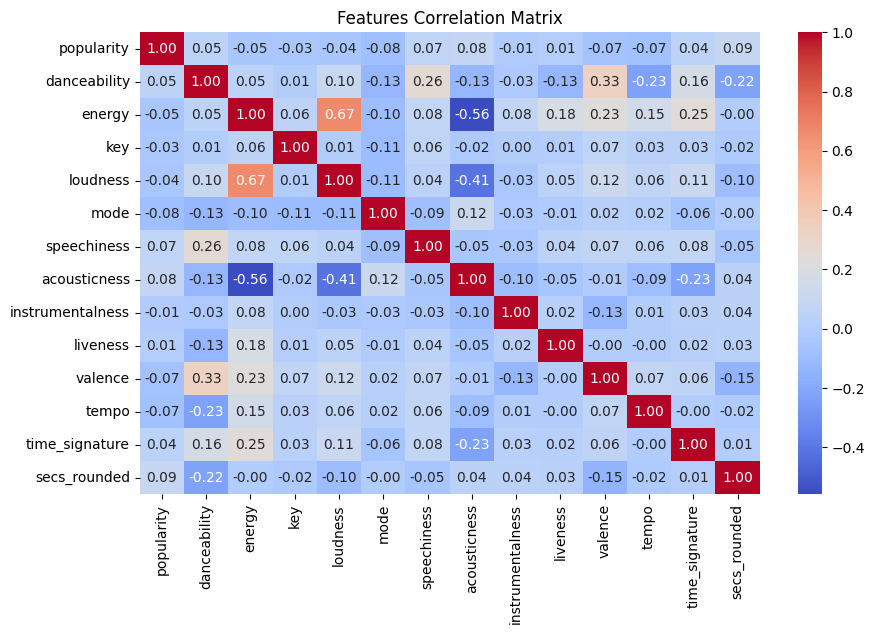

In [18]:
music_matrix = music_magic.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(music_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Features Correlation Matrix')
plt.show()

# this interactive plotly matrix works
# fig = px.imshow(music_matrix_1, aspect="auto")
# fig.show()

#notes
# the 2 strongest correlations I'm seeing is Energy & Loudness + Danceability & Valence.
# So Genre is going to be largest comparison to the other audible features

In [19]:
# this is a curated df meant to showcase the numerical data visually based on genres' features
visuals = new_df.drop(columns=['artist', 'album'], axis=1)

# segmented genres
p_visuals = visuals[visuals['genre'] == 'pop']
r_visuals = visuals[visuals['genre'] == 'rock']
hh_visuals = visuals[visuals['genre'] == 'hip-hop']
rnb_visuals = visuals[visuals['genre'] == 'r-n-b']
edm_visuals = visuals[visuals['genre'] == 'edm']

In [20]:
fig = px.scatter(visuals, x="energy", y="loudness",
 	         size="key", color="genre",
                  hover_name="valence", log_x=True, size_max=15, title='Energy and Loudness Grouped by Genre') #changing the size_max scales the circles' sizes
fig.show()

In this scatterplot it visualizes songs between energy and loudness. The circle size of each scatter point is determined by the key of the song. The higher key values represents songs with higher key values and the smaller circles represent songs with lower key values.

The trend with this scatterplot seems to be a positive relationship between energy and loudness, which makes sense since high energy songs are often louder, and low energy songs tend to be softer.  

In [21]:
fig = px.bar(visuals, x="genre", y="key", color="explicit", title="Explicit Lyrics by Genre")
fig.show()

After analyzing the bar graphs for the genres we are working with, it becomes clear that there is a distinct difference between songs with explicit lyrics and those without. The data shows that the hip-hop genre has the highest number of songs containing explicit lyrics, while the rock genre features significantly fewer explicit tracks.

I want to create a full visual analysis (pie chart, smth else) but also respectively for all 5 genres in the form of a function.
analyzing them from a -- key(bar), energy, loudness, tempo (histogram), danceability, valence(pie)

## All 5 Genre Line-Ups

### Pop Visuals

In [22]:
fig = px.scatter(p_visuals, x="energy", y="loudness",
	         size="key", color="valence",
                 hover_name="genre", log_x=True, size_max=30, title='Energy vs Loudness of Songs Categorized by Valence') #changing the size_max scales the circles' sizes
fig.show()

In [23]:
p_visuals['valence'].describe()

count    1000.000000
mean        0.506223
std         0.212209
min         0.038300
25%         0.344000
50%         0.498000
75%         0.678250
max         0.969000
Name: valence, dtype: float64

In this scatter plot, we examine the relationship between energy and loudness, categorized by the valence of the songs. Valence refers to the mood of the song, with higher values indicating happier emotions and lower values suggesting sadder or more negative moods.

In our dataset, the mean valence for pop songs is approximately 0.5177, indicating a generally positive mood. Additionally, 75% of the pop songs have a valence of 0.67425 or lower, which shows that a significant portion of pop songs tends to be more upbeat.

This analysis suggests that energy and loudness are correlated with the valence of the songs, helping to identify their emotional content.

In [24]:
fig = px.sunburst(p_visuals, path=['explicit', 'key', 'tempo'], values='popularity',
                  title='Pop Genre Popularity Scale - Categorized by the Lyrical Explicitness, their keys and tempo')
#the values here start from center to outer and its popularity is viewed via hovering.
fig.show()

In the sunburst chart we created, it visualizes the lyrical explicitness, key, and tempo of songs. The songs are divided into non-explicit, represented by blue, and explicit songs, represented by red. Most songs are categorized as non-explicit, as this occupies the majority of the chart. The chart is divided into three sections: the center categorizes the songs by explicitness (non-explicit or explicit), the second layer represents the keys of the songs, and the third layer illustrates the tempo of the songs.

### Rock Genre

In [25]:
 fig = px.scatter(r_visuals, x="energy", y="loudness",
 	         size="key", color="valence",
                  hover_name="genre", log_x=True, size_max=30, title='Energy vs Loudness of Songs Categorized by Valence') #changing the size_max scales the circles' sizes
 fig.show()

In [26]:
r_visuals['valence'].describe()

count    1000.000000
mean        0.538903
std         0.234430
min         0.058200
25%         0.355750
50%         0.546000
75%         0.718000
max         0.976000
Name: valence, dtype: float64

In this scatter plot, we also compare the energy of the songs to their loudness, categorized by the valence of the songs. As shown by the visual and the descriptive statistics, the average valence for rock songs is approximately 0.547992, indicating a generally positive mood. Additionally, 75% of the rock songs have a valence of 0.699250 or lower, suggesting that most rock songs tend to be upbeat. In contrast, 25% of the songs have a valence of 0.369750, indicating that a portion of rock songs may convey more negative or sadder emotions.

In [27]:
fig = px.sunburst(r_visuals, path=['explicit', 'key', 'tempo'], values='popularity',
                   title='Rock Genre Popularity Scale - Categorized by the Lyrical Explicitness, their keys and tempo')
# the values here start from center to outer and its popularity is viewed via hovering.
fig.show()

We also created a sunburst chart to visualize the lyrical explicitness, key, and tempo for the rock genre. The center of the sunburst chart represents the explicitness of the songs, categorized as explicit (red) and non-explicit (blue). As you can see, most of the songs in the rock genre are categorized as non-explicit. The second layer represents the key of the songs, ranging from 0 to 11, while the outer layer displays the tempo of the songs.

### Hip-Hop Genre

In [28]:
fig = px.scatter(hh_visuals, x="energy", y="loudness",
	         size="key", color="valence",
                 hover_name="genre", log_x=True, size_max=30, title='Energy vs Loudness of Songs Categorized by Valence in Hip-Hop') #changing the size_max scales the circles' sizes
fig.show()

In [29]:
hh_visuals['valence'].describe()

count    1000.000000
mean        0.551248
std         0.224913
min         0.037200
25%         0.388750
50%         0.550000
75%         0.722000
max         0.965000
Name: valence, dtype: float64

According to the scatter plot we created, the darker colors represent lower valence, while the lighter colors indicate higher valence for hip-hop songs. You can see that most of the songs are in lighter colors, suggesting they have a higher valence. Hip-hop songs have a mean valence of approximately 0.569016, with 75% of the songs having a valence of 0.744250. Compared to the previous genres, this indicates that hip-hop has a more positive mood than both rock and pop.

In [30]:
fig = px.sunburst(hh_visuals, path=['explicit', 'key', 'tempo'], values='popularity',
                  title='Hip-Hop Genre Popularity Scale - Categorized by the Lyrical Explicitness, their keys and tempo')
#the values here start from center to outer and its popularity is viewed via hovering.
fig.show()

In this sunburst chart, we compared lyrical explicitness with key and tempo. Although hip-hop has a higher valence than rock and pop, we can observe that this genre contains more than 25% of songs with explicit lyrics.

### R&B Genre

In [31]:
fig = px.scatter(rnb_visuals, x="energy", y="loudness",
	         size="key", color="valence",
                 hover_name="genre", log_x=True, size_max=30, title='Energy vs Loudness of Songs Categorized by Valence in RnB Genre') #changing the size_max scales the circles' sizes
fig.show()

In [32]:
rnb_visuals['valence'].describe()

count    1000.000000
mean        0.633164
std         0.241621
min         0.036400
25%         0.455000
50%         0.650000
75%         0.847250
max         0.994000
Name: valence, dtype: float64

he R&B genre exhibits a more scattered pattern compared to the previous charts (hip-hop, rock, and pop). According to the visual provided, 75% of the songs in the R&B genre have a valence of 0.81, indicating that most of the songs convey a more positive mood. In contrast, 25% of the songs have a valence of 0.43, suggesting that a portion of R&B songs may have a darker or more negative emotional tone.

In [33]:
fig = px.sunburst(rnb_visuals, path=['explicit', 'key', 'tempo'], values='popularity',
                  title='RnB Genre Popularity Scale - Categorized by the Lyrical Explicitness, their keys and tempo')
#the values here start from center to outer and its popularity is viewed via hovering.
fig.show()

In [34]:
rnb_visuals['key'].describe()

count    1000.000000
mean        5.743000
std         3.504173
min         0.000000
25%         2.000000
50%         7.000000
75%         9.000000
max        11.000000
Name: key, dtype: float64

In [35]:
rnb_visuals['tempo'].describe()

count    1000.000000
mean      124.038939
std        28.431107
min        51.037000
25%       101.502000
50%       124.378500
75%       143.860500
max       206.641000
Name: tempo, dtype: float64

In this sunburst chart created for the R&B genre, we can see that the majority of the songs do not have explicit lyrics. The average key for R&B songs is 5.7, which suggests that songs in a higher key may sound brighter and more energetic, while those in a lower key may sound deeper and more relaxed. Notably, 75% of the songs have a key value of 9 or higher, indicating a tendency towards more energetic keys, while 25% of the songs have a key value of 2, suggesting that a portion of the songs is more relaxed.

Regarding tempo, 75% of the R&B songs have a tempo of 140 BPM or higher, which is considered a high tempo (over 120 BPM). Conversely, 25% of the songs have a lower tempo, generally considered to be 100 BPM or less.

### EDM Genre

In [36]:
fig = px.scatter(edm_visuals, x="energy", y="loudness",
	         size="key", color="valence",
                 hover_name="genre", log_x=True, size_max=30, title='Energy vs Loudness for EDM Songs Categorized by Valence') #changing the size_max scales the circles' sizes
fig.show()

In [37]:
edm_visuals['valence'].describe()

count    1000.000000
mean        0.465198
std         0.198346
min         0.034100
25%         0.318000
50%         0.466000
75%         0.619000
max         0.962000
Name: valence, dtype: float64

While comparing energy and loudness by the valence of the songs, we can see that the EDM genre in our dataset has a mean valence of approximately 0.439007, making it the lowest among the genres analyzed. Additionally, 75% of the EDM songs have a valence of 0.62, while 25% have a valence of 0.283500.

In [38]:
fig = px.sunburst(edm_visuals, path=['explicit', 'key', 'tempo'], values='popularity',
                  title='EDM Genre Popularity Scale - Categorized by the Lyrical Explicitness, their keys and tempo')
#the values here start from center to outer and its popularity is viewed via hovering.
fig.show()

In [39]:
edm_visuals['key'].describe()

count    1000.000000
mean        5.754000
std         3.508246
min         0.000000
25%         2.000000
50%         6.000000
75%         8.000000
max        11.000000
Name: key, dtype: float64

In [40]:
edm_visuals['tempo'].describe()

count    1000.000000
mean      122.037299
std        22.292960
min        73.735000
25%       105.076000
50%       123.010500
75%       127.852500
max       213.928000
Name: tempo, dtype: float64

In [41]:
edm_visuals['explicit'].value_counts()

explicit
False    894
True     106
Name: count, dtype: int64

After comparing explicit lyrics, key, and tempo in the EDM genre, we see that there are a total of 109 songs without explicit lyrics and 11 songs that do contain explicit lyrics. This means that approximately 9% of the total EDM songs have explicit lyrics, while 91% do not.

The average key for the EDM genre is 5.62, indicating that most songs fall in the middle range rather than being distinctly high or low. The average tempo of EDM songs is 123.79 BPM, which is considered upbeat, suggesting that the majority of EDM tracks maintain a lively and energetic pace.



### This is the entire Genres Analysis

In [42]:
# # revist this function to include ALL genres | should have at least 113k rows


# main_genres = g

# def filter_genre(df, genres):
#     return df[df['genre'].isin(genres)]

# filtered_df = filter_genre(data, main_genres) #this takes the function above and filters the sub-genres away from main ones

# sampled_df = [] #this is the actual filtering for-loop
# for genre in main_genres:
#     genre_df = filtered_df[filtered_df['genre'] == genre]  # filters the genres
#     sampled_songs = genre_df.sample(n=999, random_state=12345)  # Get 120 songs per genre
#     sampled_df.append(sampled_songs)

# new_df = pd.concat(sampled_df)
# print(new_df.shape)

In [43]:
music_magic_1 = data.drop(columns=['artist', 'album', 'track_name','explicit', 'duration_ms', 'genre'], axis=1)
music_magic_1.describe()

# notes
# On a scale from 0-100; the avg popularity for a song is at
# On a scale of 0-1; the avg danceability is %
# On a scale of 0-1; the avg energy is at %
# On a scale of 0-1; the avg valence/happiness a song has is at
# On a scale of 0-243; the avg is  bpm (this is a moderate standard tempo)
# On a scale of XX-XXX
# ig we're going with genre, popularity, danceability and tempo? -- I need to do a correlation matrix

popularity   danceability         energy            key  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean       33.238827       0.566801       0.641383       5.309126   
std        22.304959       0.173543       0.251530       3.559999   
min         0.000000       0.000000       0.000000       0.000000   
25%        17.000000       0.456000       0.472000       2.000000   
50%        35.000000       0.580000       0.685000       5.000000   
75%        50.000000       0.695000       0.854000       8.000000   
max       100.000000       0.985000       1.000000      11.000000   

            loudness           mode    speechiness   acousticness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean       -8.258950       0.637558       0.084652       0.314907   
std         5.029357       0.480708       0.105733       0.332522   
min       -49.531000       0.000000       0.000000       0.000000   
25%       -10.013000       0.000000       0.035900       0.016900   
50%        -7.004000       1.000000       0.048900       0.169000   
75%        -5.003000       1.000000       0.084500       0.597500   
max         4.532000       1.000000       0.965000       0.996000   

       instrumentalness       liveness        valence          tempo  \
count     113999.000000  113999.000000  113999.000000  113999.000000   
mean           0.156051       0.213554       0.474066     122.147695   
std            0.309556       0.190378       0.259261      29.978290   
min            0.000000       0.000000       0.000000       0.000000   
25%            0.000000       0.098000       0.260000      99.218500   
50%            0.000042       0.132000       0.464000     122.017000   
75%            0.049000       0.273000       0.683000     140.071000   
max            1.000000       1.000000       0.995000     243.372000   

       time_signature   secs_rounded  
count   113999.000000  113999.000000  
mean         3.904034     228.513329  
std          0.432623     107.298806  
min          0.000000       9.000000  
25%          4.000000     175.000000  
50%          4.000000     213.000000  
75%          4.000000     262.000000  
max          5.000000    5238.000000

In [44]:
music_matrix_1 = music_magic_1.corr()
#plt.figure(figsize=(10, 6))
#sns.heatmap(music_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Features Correlation Matrix')
#plt.show()

# this interactive plotly matrix works
fig = px.imshow(music_matrix_1, aspect="auto")
fig.show()

In [45]:
fig = px.scatter(data, x="energy", y="loudness",
	         size="key", color="genre",
                 hover_name="valence", log_x=True, size_max=15, title='Energy and Loudness Grouped by Genre') #changing the size_max scales the circles' sizes
fig.show()

### Danceability

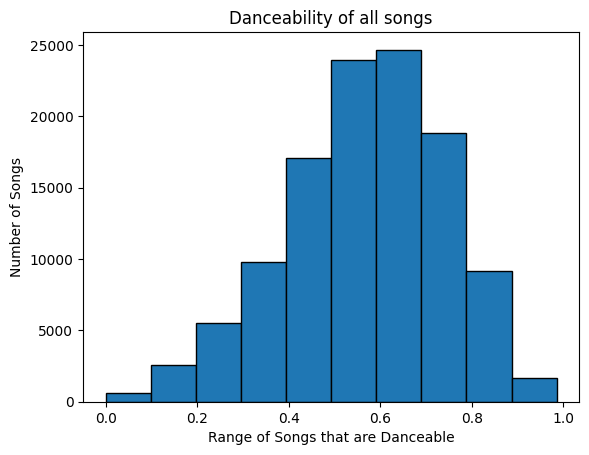

In [46]:
data['danceability'].plot(
kind='hist', edgecolor='black')
plt.title("Danceability of all songs")
plt.xlabel("Range of Songs that are Danceable")
plt.ylabel("Number of Songs")
plt.show()

By creating a histogram of the danceability of the songs, we can observe that it follows a normal distribution. The histogram is bell-shaped, featuring a single peak, with most values clustering around the mean.

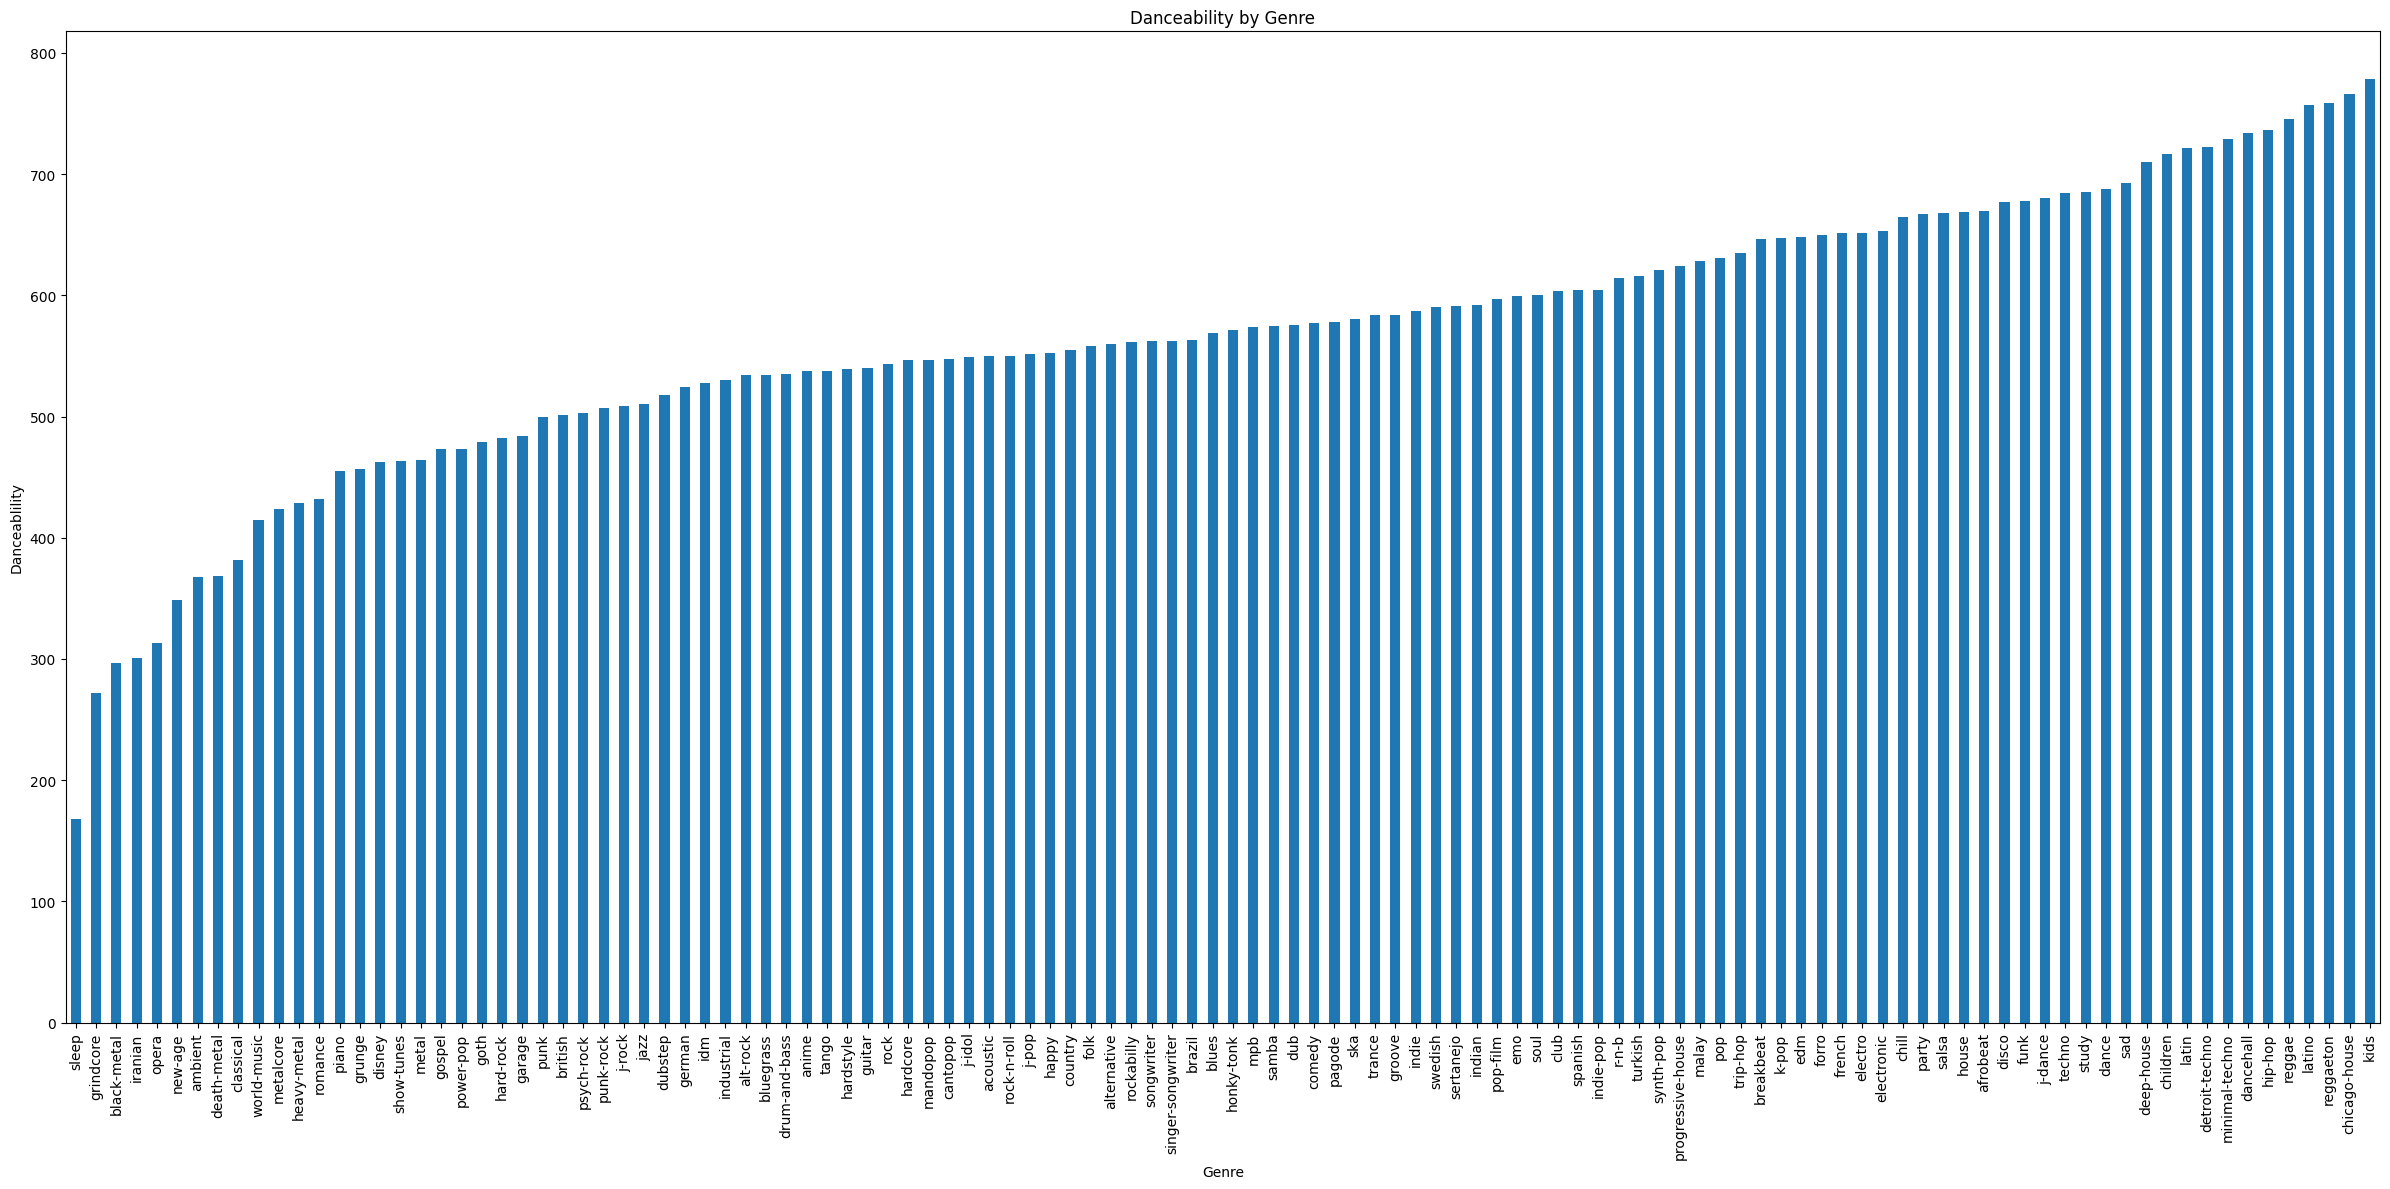

In [47]:
bar_graph = data.groupby("genre")["danceability"].sum().sort_values()
bar_graph.plot(kind="bar",
              title="Danceability by Genre",
              ylabel = "Danceablility",
              figsize=(24,12)
              )
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

After grouping the data by genre, graphed the danceability of each genre. The results show that Kids is the most danceable genre, while sleep is the least danceable.

### Loudness

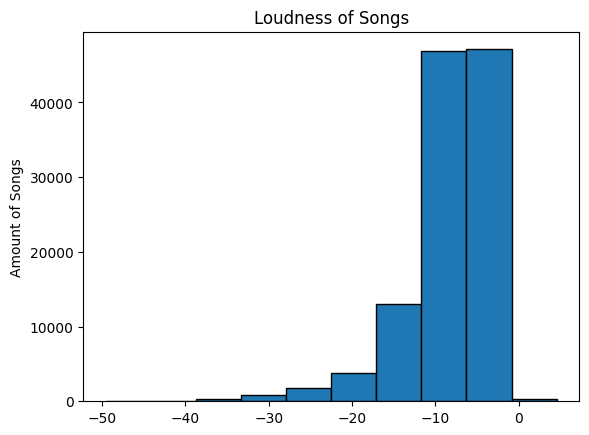

In [48]:
data['loudness'].plot(
kind='hist', edgecolor='black')
plt.title("Loudness of Songs")
plt.ylabel("Amount of Songs")
plt.show()

Considering the loudness of the songs in our dataframe, the histogram demonstrates a normal distribution, characterized by a bell-shaped curve. Most values are concentrated around the mean, indicating that the loudness levels of the songs follow this typical pattern.

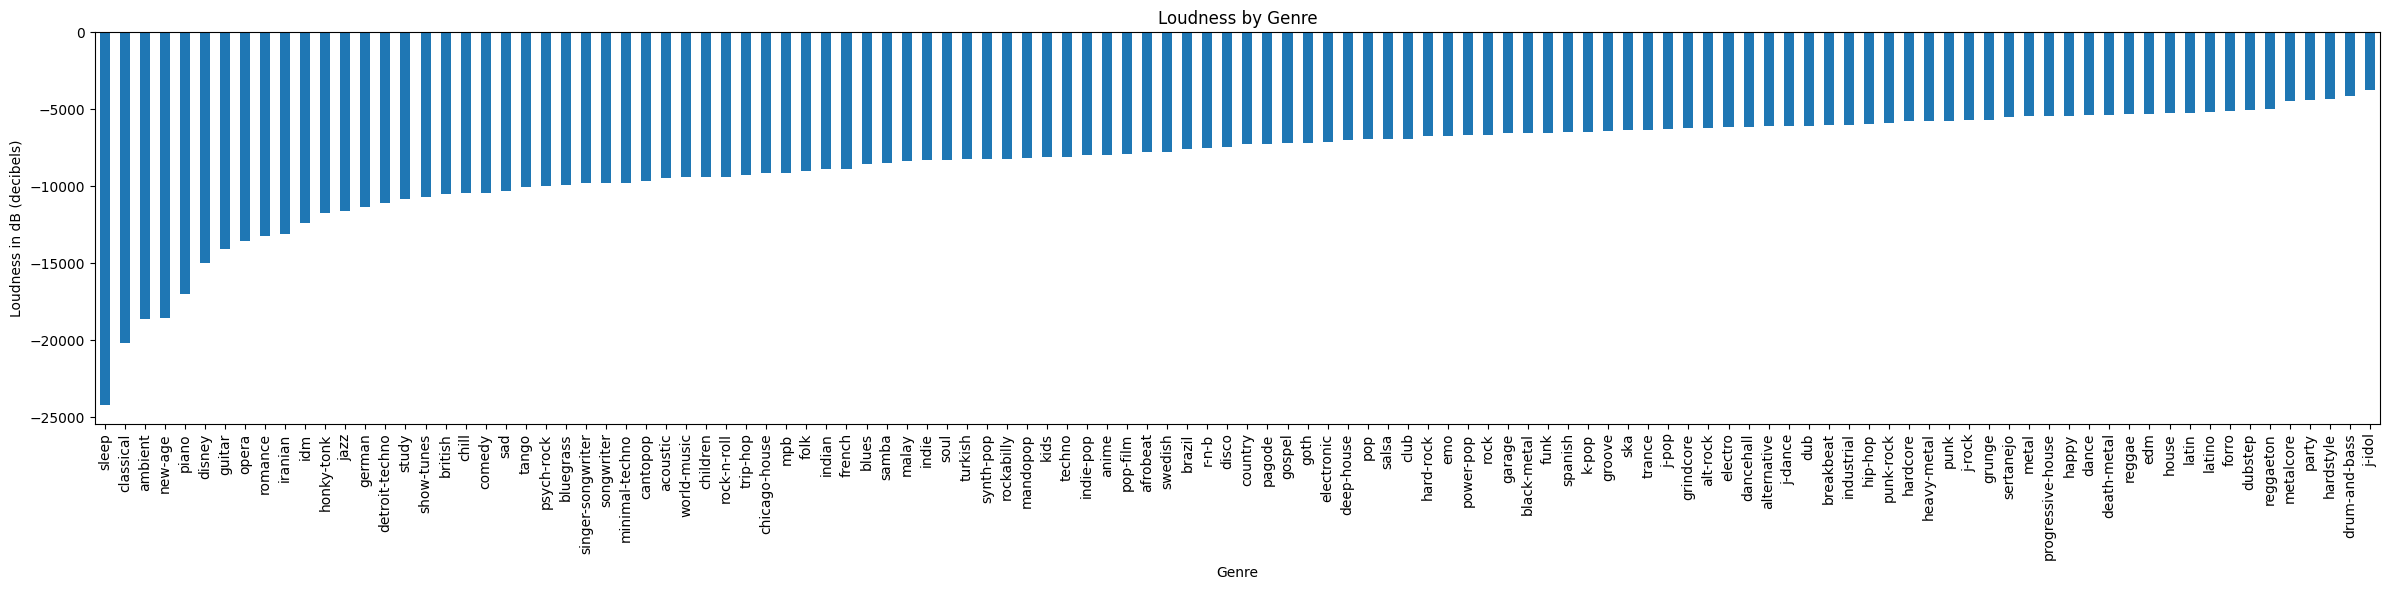

In [49]:
# Sample 75 values and group by genre, summing the loudness
bar_graph = data.groupby("genre")["loudness"].sum().sort_values()

# Create a bar graph
bar_graph.plot(kind="bar",
               title="Loudness by Genre",
               ylabel="Loudness in dB (decibels)",
               xlabel="Genre",
               figsize=(24,6)
              )
# Show the plot
plt.tight_layout()
plt.show()


In the histogram above, we plotted the loudness of various genres using decibels (dB) as the measurement tool. The genre with the lowest decibel level is sleep, followed by classical. The genre with the highest decibel level is J-Idol.

### Popularity

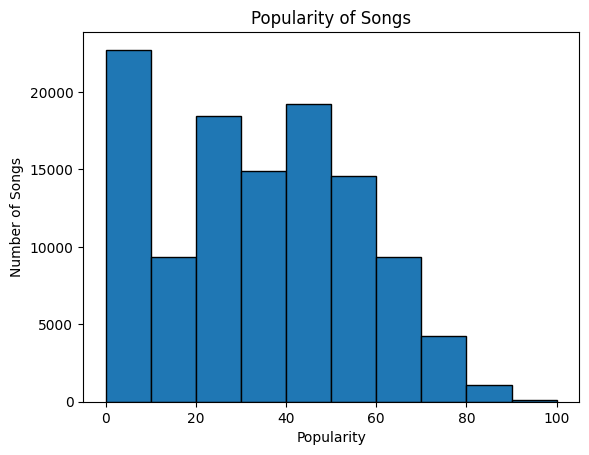

In [50]:
data['popularity'].plot(
    kind='hist',
    edgecolor='black'
)

# Add title and labels
plt.title("Popularity of Songs")
plt.xlabel("Popularity")
plt.ylabel("Number of Songs")

# Show the plot
plt.show()


Right-skewed: The distribution is skewed to the right, indicating that most songs have a relatively low popularity, while a few songs have exceptionally high popularity.  

Peak: The peak of the histogram is around 0-10, suggesting that the most common range of song popularity is between 0 and 10.


In [51]:
display(data['genre'].value_counts())

genre
acoustic             1000
afrobeat             1000
psych-rock           1000
progressive-house    1000
power-pop            1000
                     ... 
emo                  1000
electronic           1000
electro              1000
world-music          1000
k-pop                 999
Name: count, Length: 114, dtype: int64

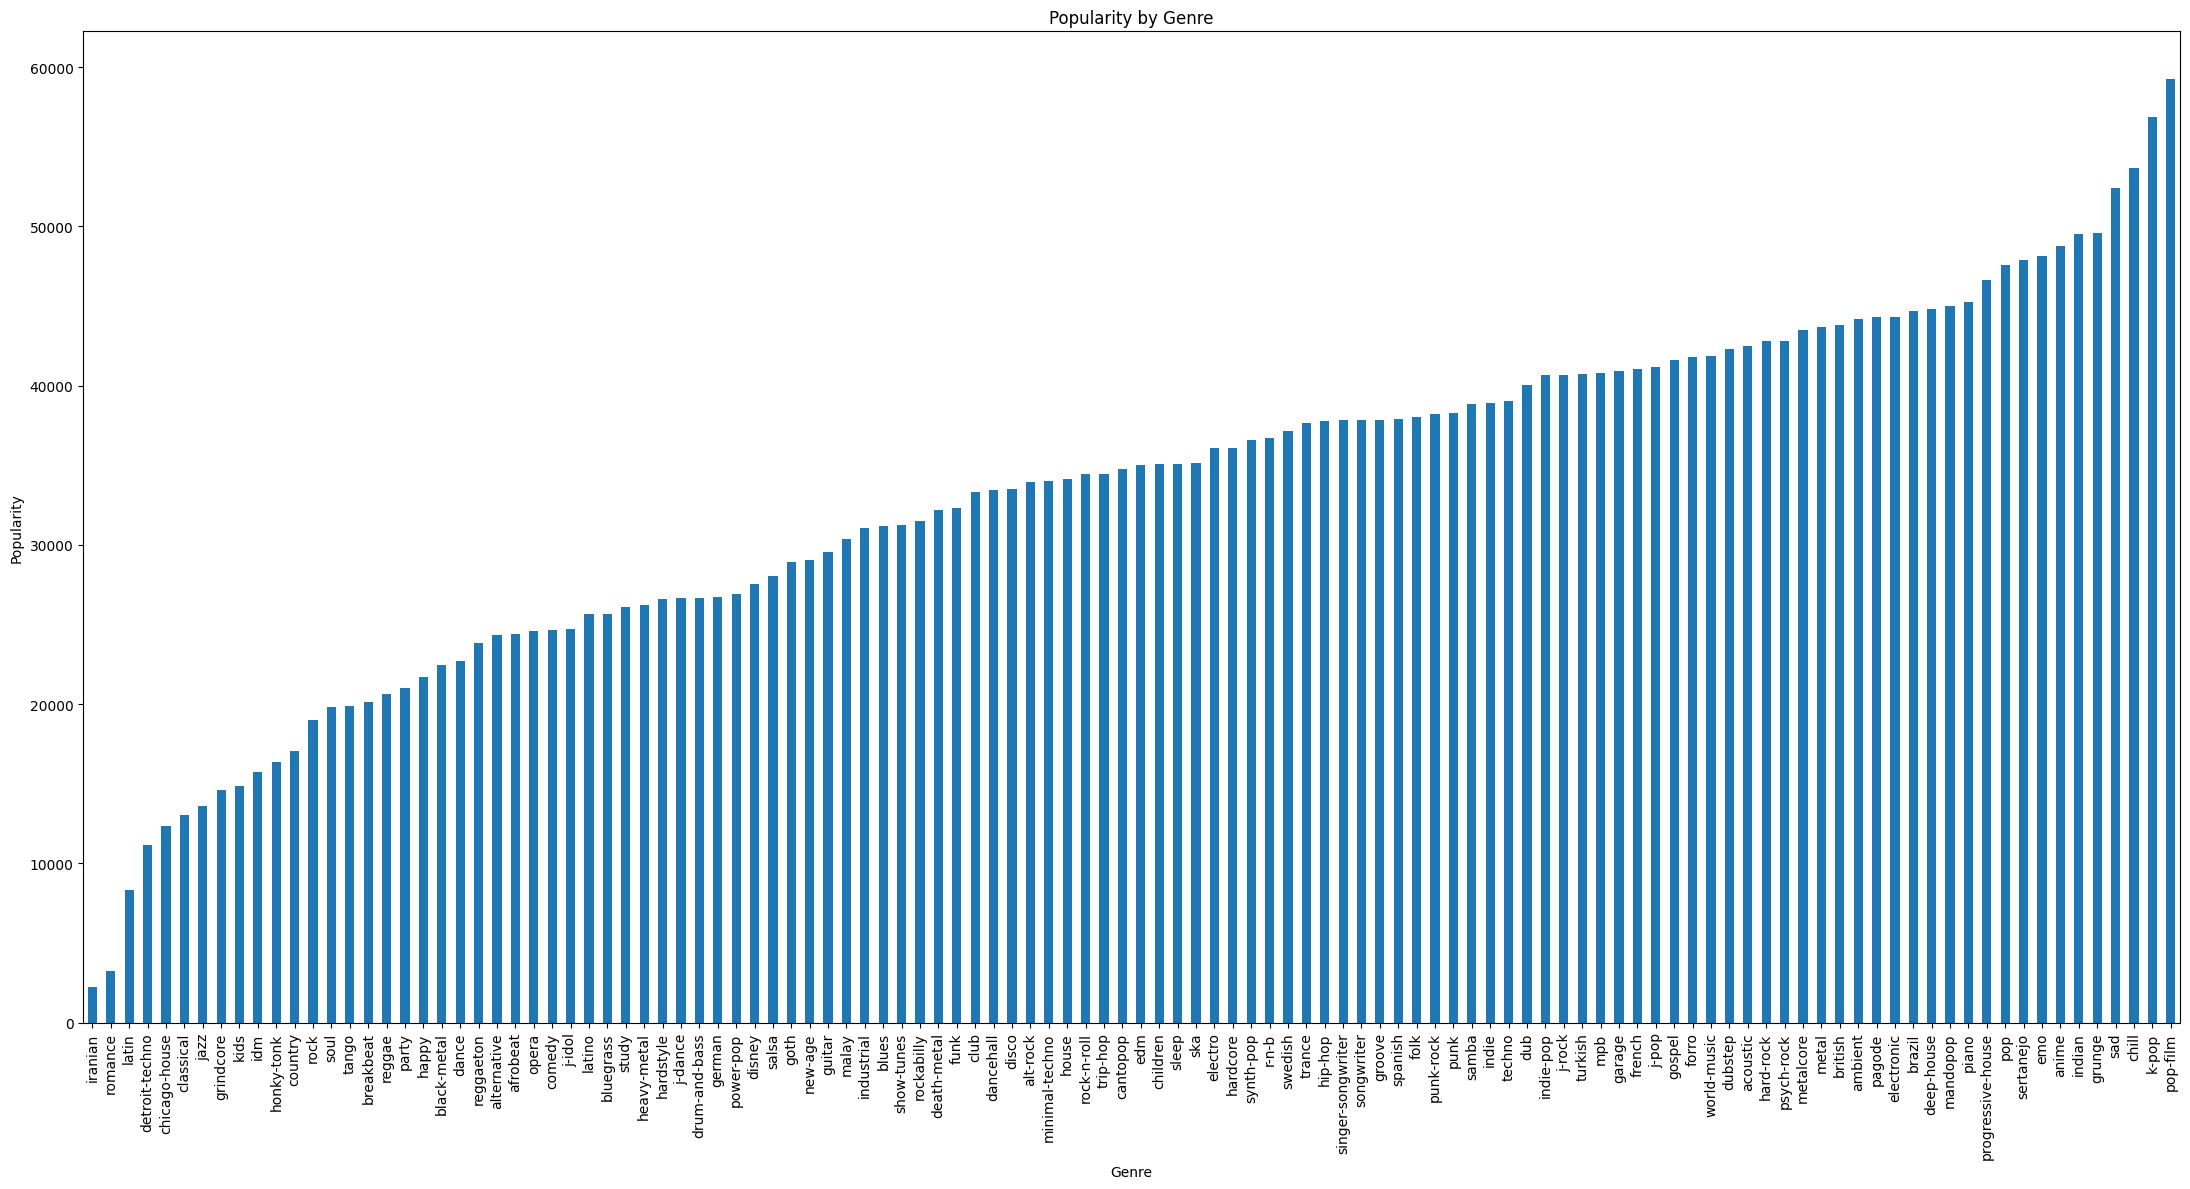

In [52]:

bar_graph = data.groupby("genre")["popularity"].sum().sort_values()


bar_graph.plot(kind="bar",
               title="Popularity by Genre",
               ylabel="Popularity",
               xlabel="Genre",
               figsize=(22,12)
              )
plt.tight_layout()
plt.show()



In this dataset, we examined the popularity of different genres based on all of the genres. The analysis shows that Pop-Film is the most popular genre, followed by K-Pop in second place. Chill ranks third, while Iranian Music is the least popular genre in the dataset.

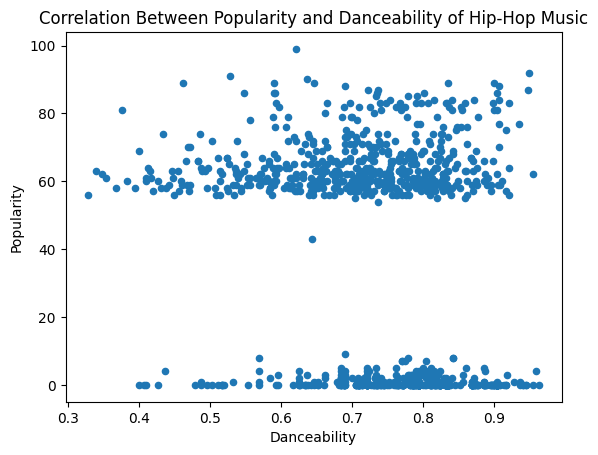

In [53]:
correlation_hiphop = data[data["genre"] == "hip-hop" ]

correlation_hiphop.plot(kind="scatter",
       x="danceability",
       y="popularity",
       ylabel="Popularity",
       xlabel="Danceability",
       title="Correlation Between Popularity and Danceability of Hip-Hop Music")
plt.show()

We did not find a correlation between danceability and song popularity.

## Machine Learning

In [54]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist            113999 non-null  object 
 1   album             113999 non-null  object 
 2   track_name        113999 non-null  object 
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  bool   
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

artist                                              album  \
0             Gen Hoshino                                             Comedy   
1            Ben Woodward                                   Ghost (Acoustic)   
2  Ingrid Michaelson;ZAYN                                     To Begin Again   
3            Kina Grannis  Crazy Rich Asians (Original Motion Picture Sou...   
4        Chord Overstreet                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature     genre  \
0          0.000001    0.3580    0.715   87.917               4  acoustic   
1          0.000006    0.1010    0.267   77.489               4  acoustic   
2          0.000000    0.1170    0.120   76.332               4  acoustic   
3          0.000071    0.1320    0.143  181.740               3  acoustic   
4          0.000000    0.0829    0.167  119.949               4  acoustic   

   secs_rounded  
0           231  
1           150  
2           211  
3           202  
4           199

### Define Features & Target

In [55]:
# Come back to drop ['explicit'] if necessary
# Dropping columns not necessary for models

data = data.drop(['track_name', 'artist', 'album', 'explicit'], axis=1)

In [56]:
#Define features and target
X = data.drop(columns=['genre'])
y = data['genre']

### Splitting Data

In [57]:
def train_val_test_split(X, y, stratify=None, rstate=42, shuffle=True):
    strat = stratify if stratify is not None else None

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=rstate, shuffle=shuffle
    )

    return (X_train, X_val, X_test, y_train, y_val, y_test)


In [58]:
X = data.drop(columns=['genre'])
y = data['genre']

In [59]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, stratify=y)

In [60]:
# #splitting data into training, validation, and test sets at a ratio of 60:20:20

# #split training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

# #split validation set
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345, stratify=y_train)

# print(X_train.shape)
# print(y_train.shape)
# print(X_valid.shape)
# print(X_test.shape)


### Encoding

In [61]:
#One-Hot encoding the target column
categorical_cols = ['genre']
# data_ohe_train = pd.get_dummies(y_train, columns=categorical_cols, drop_first=True)
# data_ohe_valid = pd.get_dummies(y_test, columns=categorical_cols, drop_first=True)
# data_ohe_test = pd.get_dummies(y_valid, columns=categorical_cols, drop_first=True)

In [62]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


### Feature Scaling

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68399 entries, 111067 to 46962
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        68399 non-null  int64  
 1   duration_ms       68399 non-null  int64  
 2   danceability      68399 non-null  float64
 3   energy            68399 non-null  float64
 4   key               68399 non-null  int64  
 5   loudness          68399 non-null  float64
 6   mode              68399 non-null  int64  
 7   speechiness       68399 non-null  float64
 8   acousticness      68399 non-null  float64
 9   instrumentalness  68399 non-null  float64
 10  liveness          68399 non-null  float64
 11  valence           68399 non-null  float64
 12  tempo             68399 non-null  float64
 13  time_signature    68399 non-null  int64  
 14  secs_rounded      68399 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 8.3 MB


In [64]:
def scaling(X_train, X_valid, X_test):
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    return X_train, X_valid, X_test

scaling(X_train, X_val, X_test)

(array([[ 0.83979039,  0.72072745,  0.90097942, ..., -0.22283658,
          0.22278611,  0.72157374],
        [ 0.88458543, -0.552401  ,  0.49756694, ..., -0.67207277,
          0.22278611, -0.5530501 ],
        [-0.0113155 ,  0.75071102,  0.31314981, ...,  0.3876185 ,
          0.22278611,  0.75054246],
        ...,
        [ 1.3325359 , -0.15732281, -1.3638935 , ...,  0.69753671,
          0.22278611, -0.15714421],
        [-0.54885606,  0.81688732, -0.26315373, ..., -1.24770671,
         -2.0815156 ,  0.81813615],
        [-0.77283129,  1.61644919,  0.23246731, ...,  1.32388333,
          0.22278611,  1.61960418]]),
 array([[-1.48955204e+00,  1.55284153e+00, -1.40999779e+00, ...,
          1.73449241e+00, -2.08151560e+00,  1.55201049e+00],
        [-3.69675871e-01, -3.01122898e-03, -1.23710672e+00, ...,
         -2.52750052e-01, -2.08151560e+00, -2.64435233e-03],
        [-1.48955204e+00, -7.33432240e-01,  1.02200317e+00, ...,
         -1.27241202e+00, -2.08151560e+00, -7.36518687e-

In [65]:
xtrain, xval, xtest = scaling(X_train, X_val, X_test)

In [66]:
from scipy.stats import ks_2samp

# Example for comparing a single feature
for col in X_train.columns:
    stat, p_value = ks_2samp(X_train[col], X_val[col])
    print(f'Feature: {col} - KS Statistic: {stat}, p-value: {p_value}')


Feature: popularity - KS Statistic: 0.004247473480555097, p-value: 0.9159331326954623
Feature: duration_ms - KS Statistic: 0.005361031106692504, p-value: 0.7073771964876334
Feature: danceability - KS Statistic: 0.007579934737939886, p-value: 0.2781497771048844
Feature: energy - KS Statistic: 0.007269455822043136, p-value: 0.3251858090017533
Feature: key - KS Statistic: 0.007524725918071518, p-value: 0.2861377803430004
Feature: loudness - KS Statistic: 0.00668628709304514, p-value: 0.4272612118005068
Feature: mode - KS Statistic: 0.0038982237351884996, p-value: 0.9564514674109224
Feature: speechiness - KS Statistic: 0.004614348137335578, p-value: 0.8580356399136743
Feature: acousticness - KS Statistic: 0.004850342789971013, p-value: 0.8140393520011542
Feature: instrumentalness - KS Statistic: 0.007566695855561689, p-value: 0.280050515427234
Feature: liveness - KS Statistic: 0.007725357890992046, p-value: 0.25788064256849985
Feature: valence - KS Statistic: 0.010648301901407753, p-value:

Had to add this step because for some reason with the previous splitting there were problems causing the ML algorithms to crash, so i did this test and redid the splitting

#### Evaluation Metrics

The primary evaluation metric for the models will be the F1 score. This score takes the mean of precision and recall scores and ranges between 0 and 1.

The secondary evaluation metric for our models is accuracy score. The accuracy score is a percentage of predictions that were made corrrectly by the model.

In [67]:
# evaluation function to score and plot F1 score and confusion matrix

def eval_classifier(y_true, y_pred):

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1: {f1:.2f}')

    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy Score:', accuracy)

    # print('\n--------------- Classification Report ---------------\n')
    # print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [68]:
xtrain

array([[ 0.83979039,  0.72072745,  0.90097942, ..., -0.22283658,
         0.22278611,  0.72157374],
       [ 0.88458543, -0.552401  ,  0.49756694, ..., -0.67207277,
         0.22278611, -0.5530501 ],
       [-0.0113155 ,  0.75071102,  0.31314981, ...,  0.3876185 ,
         0.22278611,  0.75054246],
       ...,
       [ 1.3325359 , -0.15732281, -1.3638935 , ...,  0.69753671,
         0.22278611, -0.15714421],
       [-0.54885606,  0.81688732, -0.26315373, ..., -1.24770671,
        -2.0815156 ,  0.81813615],
       [-0.77283129,  1.61644919,  0.23246731, ...,  1.32388333,
         0.22278611,  1.61960418]])

### Model Training

#### Multiclass Logistic Regression

This was added because we can solve this using a normal ordinal encoding since it doesnt matter to use it for the output, at least in this case. Tomorrow i can explain better in a call.

In [69]:
%%time

lr_clf = LogisticRegression() #multi_class='ovr' is the default one vs all multiclass regression classifer. It is efficient and more easily interpretable than other multi-class logistic regression strategies

lr_clf.fit(xtrain, y_train_encoded)

CPU times: user 27.3 s, sys: 16.7 s, total: 44 s
Wall time: 31.6 s


LogisticRegression()

In [70]:
eval_classifier(y_train_encoded, lr_clf.predict(xtrain))

F1: 0.17
Accuracy Score: 0.2023713796985336
Confusion Matrix
[[1.06726707e-03 0.00000000e+00 4.38602904e-05 ... 0.00000000e+00
  4.38602904e-05 2.63161742e-04]
 [2.92401936e-05 1.25732832e-03 1.46200968e-05 ... 4.38602904e-05
  1.46200968e-05 2.92401936e-05]
 [1.46200968e-05 0.00000000e+00 2.92401936e-05 ... 0.00000000e+00
  2.92401936e-05 1.75441161e-04]
 ...
 [1.46200968e-05 2.77781839e-04 0.00000000e+00 ... 7.45624936e-04
  1.46200968e-04 2.33921549e-04]
 [2.92401936e-05 1.46200968e-05 8.77205807e-05 ... 1.46200968e-05
  7.60245033e-04 8.77205807e-05]
 [1.16960774e-04 0.00000000e+00 1.31580871e-04 ... 0.00000000e+00
  0.00000000e+00 2.57313703e-03]]


In [71]:
eval_classifier(y_valid_encoded, lr_clf.predict(xval))

F1: 0.17
Accuracy Score: 0.2000438596491228
Confusion Matrix
[[1.14035088e-03 4.38596491e-05 4.38596491e-05 ... 0.00000000e+00
  0.00000000e+00 2.63157895e-04]
 [0.00000000e+00 1.27192982e-03 0.00000000e+00 ... 1.75438596e-04
  8.77192982e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.38596491e-05
  4.38596491e-05 1.75438596e-04]
 ...
 [0.00000000e+00 2.63157895e-04 0.00000000e+00 ... 4.38596491e-04
  4.38596491e-05 8.77192982e-05]
 [4.38596491e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.01754386e-04 4.38596491e-05]
 [1.75438596e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.75438596e-04 2.28070175e-03]]


#### Random Forest

In [72]:
rf_clf = RandomForestClassifier(random_state=42)


In [73]:
rf_clf.fit(xtrain, y_train_encoded)

y_rf_pred = rf_clf.predict(xval)

eval_classifier(y_valid_encoded, y_rf_pred)

F1: 0.31
Accuracy Score: 0.32456140350877194
Confusion Matrix
[[2.10526316e-03 4.38596491e-05 4.38596491e-05 ... 0.00000000e+00
  0.00000000e+00 1.31578947e-04]
 [0.00000000e+00 2.58771930e-03 0.00000000e+00 ... 1.75438596e-04
  2.19298246e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.63157895e-04 ... 4.38596491e-05
  4.38596491e-05 1.31578947e-04]
 ...
 [0.00000000e+00 8.77192982e-04 4.38596491e-05 ... 1.88596491e-03
  0.00000000e+00 4.38596491e-05]
 [0.00000000e+00 0.00000000e+00 8.77192982e-05 ... 4.38596491e-05
  3.11403509e-03 0.00000000e+00]
 [8.77192982e-05 0.00000000e+00 1.31578947e-04 ... 0.00000000e+00
  4.38596491e-05 3.11403509e-03]]


In [74]:
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


##### Feature Selection and Hyperparameter Tuning

In [75]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [30],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2]
}


Amount of parameters were reduced and changed after several tries of the algorithm

In [76]:
# grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf,
#                            cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(xtrain, y_train_encoded)

# best_model_rf = grid_search.best_estimator_

This is commented to prevent it from running in the future. The best algorithm was already selected before showing little improvement as to a no tunning class

In [77]:
# best_params_rf = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

In [78]:
best_model_rf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_depth=30, random_state=42)
best_model_rf.fit(xtrain, y_train_encoded)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [79]:
y_pred_rf_tuned_train = best_model_rf.predict(xtrain)
y_pred_rf_tuned_val = best_model_rf.predict(xval)
print('Training Set')
eval_classifier(y_train_encoded, y_pred_rf_tuned_train)
print('Validation Set')
eval_classifier(y_valid_encoded, y_pred_rf_tuned_val)

Training Set
F1: 0.85
Accuracy Score: 0.8535797306978172
Confusion Matrix
[[8.18725420e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.58199681e-03 0.00000000e+00 ... 1.46200968e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.94159271e-03 ... 0.00000000e+00
  5.84803871e-05 4.38602904e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.47965614e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.46503604e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.92401936e-05 ... 0.00000000e+00
  0.00000000e+00 8.71357768e-03]]
Validation Set
F1: 0.32
Accuracy Score: 0.3319736842105263
Confusion Matrix
[[2.10526316e-03 0.00000000e+00 4.38596491e-05 ... 0.00000000e+00
  0.00000000e+00 1.75438596e-04]
 [0.00000000e+00 2.71929825e-03 0.00000000e+00 ... 2.63157895e-04
  1.75438596e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.50877193e-04 ... 4

#### XGBoost Multi-Class Classification

In [80]:
%%time
xgb_clf = XGBClassifier(objective='multi:softmax',
                        eval_metric=['merror', 'mlogloss'],
                        num_class=len(y_train.unique()),
                        use_label_encoder=False,
                        random_state=42,
                        early_stopping_rounds=10)

xgb_clf.fit(xtrain, y_train_encoded,
            eval_set=[(xval, y_valid_encoded)])


[0]	validation_0-merror:0.75329	validation_0-mlogloss:3.66530
[1]	validation_0-merror:0.74272	validation_0-mlogloss:3.40544
[2]	validation_0-merror:0.73592	validation_0-mlogloss:3.25961
[3]	validation_0-merror:0.72868	validation_0-mlogloss:3.15670
[4]	validation_0-merror:0.72535	validation_0-mlogloss:3.07770
[5]	validation_0-merror:0.72189	validation_0-mlogloss:3.01613
[6]	validation_0-merror:0.71864	validation_0-mlogloss:2.96625
[7]	validation_0-merror:0.71645	validation_0-mlogloss:2.92524
[8]	validation_0-merror:0.71346	validation_0-mlogloss:2.88926
[9]	validation_0-merror:0.71149	validation_0-mlogloss:2.85768
[10]	validation_0-merror:0.70939	validation_0-mlogloss:2.83129
[11]	validation_0-merror:0.70855	validation_0-mlogloss:2.80700
[12]	validation_0-merror:0.70614	validation_0-mlogloss:2.78711
[13]	validation_0-merror:0.70575	validation_0-mlogloss:2.76791
[14]	validation_0-merror:0.70377	validation_0-mlogloss:2.75260
[15]	validation_0-merror:0.70285	validation_0-mlogloss:2.73784
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=114, num_parallel_tree=None, ...)

In [81]:
eval_classifier(y_train_encoded, xgb_clf.predict(xtrain))

F1: 0.68
Accuracy Score: 0.6844690711852512
Confusion Matrix
[[4.76615155e-03 2.92401936e-05 1.46200968e-05 ... 2.92401936e-05
  5.84803871e-05 4.38602904e-05]
 [2.92401936e-05 6.50594307e-03 0.00000000e+00 ... 8.77205807e-05
  1.02340677e-04 0.00000000e+00]
 [1.46200968e-05 0.00000000e+00 3.62578400e-03 ... 1.46200968e-05
  7.31004839e-05 1.02340677e-04]
 ...
 [0.00000000e+00 2.33921549e-04 0.00000000e+00 ... 6.52056317e-03
  4.38602904e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.31004839e-05
  6.94454597e-03 2.92401936e-05]
 [1.02340677e-04 1.46200968e-05 4.38602904e-05 ... 1.46200968e-05
  2.92401936e-05 6.53518326e-03]]


In [82]:
eval_classifier(y_valid_encoded, xgb_clf.predict(xval))

F1: 0.31
Accuracy Score: 0.3093859649122807
Confusion Matrix
[[1.84210526e-03 0.00000000e+00 8.77192982e-05 ... 4.38596491e-05
  4.38596491e-05 1.75438596e-04]
 [0.00000000e+00 2.54385965e-03 0.00000000e+00 ... 4.82456140e-04
  2.19298246e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.77192982e-04 ... 4.38596491e-05
  4.38596491e-05 1.31578947e-04]
 ...
 [0.00000000e+00 9.64912281e-04 4.38596491e-05 ... 2.41228070e-03
  8.77192982e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.38596491e-05 ... 4.38596491e-05
  3.33333333e-03 1.31578947e-04]
 [3.07017544e-04 0.00000000e+00 8.77192982e-05 ... 4.38596491e-05
  0.00000000e+00 2.41228070e-03]]


#### NN

In [83]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64),
                        activation='relu',
                        solver='adam',
                        learning_rate_init=0.001,
                        max_iter=200,
                        random_state=42)

mlp_clf.fit(xtrain, y_train_encoded)


MLPClassifier(hidden_layer_sizes=(128, 64), random_state=42)

In [84]:
y_pred_train_mlp = mlp_clf.predict(xtrain)
y_pred_valid_mlp = mlp_clf.predict(xval)
print('Training Set')
eval_classifier(y_train_encoded, y_pred_train_mlp)
print('Validation Set')
eval_classifier(y_valid_encoded, y_pred_valid_mlp)

Training Set
F1: 0.35
Accuracy Score: 0.36749075278878346
Confusion Matrix
[[1.43276948e-03 2.92401936e-05 1.46200968e-05 ... 7.31004839e-05
  1.16960774e-04 1.75441161e-04]
 [0.00000000e+00 2.80705858e-03 0.00000000e+00 ... 8.77205807e-04
  1.60821065e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.14044065e-04 ... 2.92401936e-05
  1.46200968e-05 1.02340677e-04]
 ...
 [1.46200968e-05 3.94742613e-04 1.46200968e-05 ... 3.52344333e-03
  7.31004839e-05 2.92401936e-05]
 [0.00000000e+00 0.00000000e+00 4.38602904e-05 ... 1.16960774e-04
  4.72229126e-03 5.84803871e-05]
 [1.46200968e-04 1.46200968e-05 4.38602904e-05 ... 1.46200968e-05
  7.31004839e-05 3.81584526e-03]]
Validation Set
F1: 0.30
Accuracy Score: 0.3131140350877193
Confusion Matrix
[[1.27192982e-03 0.00000000e+00 8.77192982e-05 ... 0.00000000e+00
  0.00000000e+00 1.31578947e-04]
 [0.00000000e+00 1.62280702e-03 0.00000000e+00 ... 8.33333333e-04
  1.75438596e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.14035088e-04 ... 

#### Lightbm

In [85]:
# %%time
# lgbm_clf = LGBMClassifier(
#     n_estimators=100,
#     max_depth=10,
#     learning_rate=0.01,
#     min_data_in_leaf=20,
#     random_state=42,
#     reg_alpha=1,
#     reg_lambda=1,
#     early_stopping_rounds=10
# )
# lgbm_clf.fit(xtrain, y_train_encoded, eval_set=(xval, y_valid_encoded))

In [86]:
# y_pred_train_lgbm = lgbm_clf.predict(xtrain)
# y_pred_valid_lgbm = lgbm_clf.predict(xval)
# print('Training Set')
# eval_classifier(y_train_encoded, y_pred_train_lgbm)
# print('Validation Set')
# eval_classifier(y_valid_encoded, y_pred_valid_lgbm)

#### SVC

In [87]:
svc_clf = SVC(probability=True, kernel='rbf', random_state=42)

xtrain_sample = xtrain.sample(frac=0.5, random_state=42)
y_train_encoded_sample = y_train_encoded[xtrain_sample.index]


svc_clf.fit(xtrain_sample, y_train_encoded_sample)

SVC(probability=True, random_state=42)

#### Soft Voting Classifier

In [88]:
estimators=[
    ('log_reg', lr_clf),
    ('rf_clf', best_model_rf),
    ('xgb_clf', xgb_clf),
    ('svc_clf', svc_clf),
    ('mlp_clf', mlp_clf)
]

In [89]:
def manual_soft_voting_proba(models, X):
    probas = []

    for name, model in models:
        probas.append(model.predict_proba(X))

    averaged_proba = sum(probas) / len(models)

    return averaged_proba


In [ ]:
proba_soft_voting_train = manual_soft_voting_proba(estimators, xtrain)
y_pred_soft_voting_train = np.argmax(proba_soft_voting_train, axis=1)

proba_soft_voting_val = manual_soft_voting_proba(estimators, xval)
y_pred_soft_voting_val = np.argmax(proba_soft_voting_val, axis=1)

print('Training Set')
eval_classifier(y_train_encoded, y_pred_soft_voting_train)
print('Validation Set')
eval_classifier(y_valid_encoded, y_pred_soft_voting_val)

## Conclusion